# ROMY Event Catalog

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from obspy.clients.fdsn import Client

In [2]:
from functions.catalog_to_dataframe import __catalog_to_dataframe
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth

### Configurations

In [3]:
config = {}

# ROMY coordinates
config['ROMY_lon'] = 11.275501
config['ROMY_lat'] = 48.162941

# minimal magnitude
config['minmagnitude'] = 6.0

# first region specified
config['minlatitude'] = -90
config['maxlatitude'] = 90
config['minlongitude'] = -180
config['maxlongitude'] = 180

# event file name
config['eventfile'] = "ROMY_global_catalog"

# start and end time
config['tbeg'] = obs.UTCDateTime("2019-01-01")
config['tend'] = obs.UTCDateTime("2025-05-31")

# output path
config['outpath'] = "C:/Bachelorarbeit/data/catalogs/"

config['outpath_figs'] = "C:/Bachelorarbeit/figures/"

# adjust eventfile name with time period
config['eventfile'] += f"_{str(config['tbeg'].date).replace('-','')}"
config['eventfile'] += f"_{str(config['tend'].date).replace('-','')}"

# prepare string for output file names
config['str_dates'] = f"{str(config['tbeg'].date).replace('-','')}_{str(config['tend'].date).replace('-','')}"

Methods

In [4]:
def __export_new_events(config, events_old, events):

    ## combine new and old catalog
    tmp = pd.concat([__cat_to_df(events_old), __cat_to_df(events)]).reset_index(drop=False)
    ## remove duplicates
    df = tmp.drop_duplicates(subset=['index'], keep=False)
    ## sort and set index
    df = df.sort_index(ascending=False)
    df.set_index('index', inplace=True, drop=True)

    ## export new events to pickle file
    print(f" -> export new events: {config['outpath']}new_events.pkl")
    df.to_pickle(config['outpath']+"new_events.pkl")

    del tmp, df

In [5]:
def __plot_timeline(catalog_all_df):

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    cmap = plt.get_cmap('viridis', 7)

    cax = ax.scatter(catalog_all_df.timestamp, catalog_all_df.distances_km, s=2**catalog_all_df.magnitude,
                     c=catalog_all_df.magnitude, alpha=0.6, cmap=cmap, zorder=2)


    cbar = plt.colorbar(cax, ax=ax, pad=0.01)
    cbar.set_label("Magnitude", fontsize=14)
    cax.set_clim(6, 9.5)

    ax.set_ylim(bottom=0)
    ax.set_ylabel("Distance (km)", fontsize=14)

    ax.grid(ls=":", zorder=-1)

    ax.set_xlim(config['tbeg']-15*86400, config['tend']+15*86400)

    ax.text(config['tend']-10*86400, catalog_all_df.distances_km.max(), f"Events={len(catalog_all_df)}", ha="right")

    plt.show();
    return fig

## Get Events

Get events based on configurations

In [6]:
client = Client("ISC")

# events - all in area and time period
events = client.get_events(
                           minlatitude=config['minlatitude'], maxlatitude=config['maxlatitude'],
                           minlongitude=config['minlongitude'], maxlongitude=config['maxlongitude'],
                           minmagnitude=config['minmagnitude'], maxmagnitude=9.5,
                           starttime=config['tbeg'], endtime=config['tend'],
                           )

#Store events in xml file

# store events in xml file
print(f" -> storing: {config['outpath']}{config['eventfile']}.xml")
events.write(config['outpath']+config['eventfile']+".xml", format="QUAKEML")

# plot on map
# Nur Events mit Magnitude >= 7.0
#events.plot();

 -> storing: C:/Bachelorarbeit/data/catalogs/ROMY_global_catalog_20190101_20250531.xml


Converting catalog object to dataframe

In [9]:
# convert catalog object to data frame
events_df = __catalog_to_dataframe(events)

events_df = events_df.rename_axis('timestamp').reset_index()
events_df['seconds'] = [abs((events_df.timestamp.min()-tt).total_seconds()) for tt in events_df.timestamp]
events_df
# Setzt den Pfad und Dateinamen
output_path = config['outpath'] + 'Katalog.csv'

# Speichert den DataFrame als CSV-Datei
events_df.to_csv(output_path, index=False)

#add distances and backazimuth to dataframe

# add epicentral distances
events_df=__add_distances_and_backazimuth(config, events_df)
#__add_distances_and_backazimuth(config, events_df)
events_df = events_df[events_df.magnitude > config['minmagnitude']]

events_df.reset_index(drop=True, inplace=True)

events_df

# find large events
events_df[events_df.magnitude > 7]
for ev in events:
    print(ev.origins[0].time, ev.origins[0].latitude, ev.origins[0].longitude,
          ev.magnitudes[0].mag, ev.magnitudes[0].magnitude_type,
          ev.resource_id)

# find events based on dates
# events_df[events_df.timestamp > "2023-12-03"]

2019-01-04T06:24:16.200000Z -27.96 -172.66 6.03 mb smi:ISC/evid=620348202
2019-01-05T19:25:38.000000Z -8.1802 -71.6436 6.3 mb smi:ISC/evid=614554733
2019-01-06T17:27:19.630000Z 2.3041 126.7147 6.15 mb smi:ISC/evid=614554814
2019-01-08T12:39:30.820000Z 30.5733 131.2115 5.81 mb smi:ISC/evid=614559323
2019-01-15T18:06:36.200000Z -13.4074 166.8097 5.94 mb smi:ISC/evid=614572080
2019-01-17T15:06:37.680000Z -3.2691 146.4349 5.51 mb smi:ISC/evid=614574305
2019-01-20T01:32:51.840000Z -30.0772 -71.3177 6.54 mb smi:ISC/evid=614617823
2019-01-22T05:10:05.180000Z -10.2877 119.1299 6.04 mb smi:ISC/evid=614578210
2019-01-22T19:01:42.120000Z -43.1281 42.4198 6.41 mb smi:ISC/evid=614617830
2019-01-26T08:12:50.540000Z -5.5622 133.7994 6.09 mb smi:ISC/evid=614590498
2019-02-01T16:14:12.400000Z 14.7715 -92.2794 6.09 mb smi:ISC/evid=620213281
2019-02-02T09:27:35.580000Z -2.7618 100.1937 5.96 mb smi:ISC/evid=614610371
2019-02-02T10:59:31.350000Z -2.827 100.234 5.89 mb smi:ISC/evid=614610379
2019-02-02T11:0

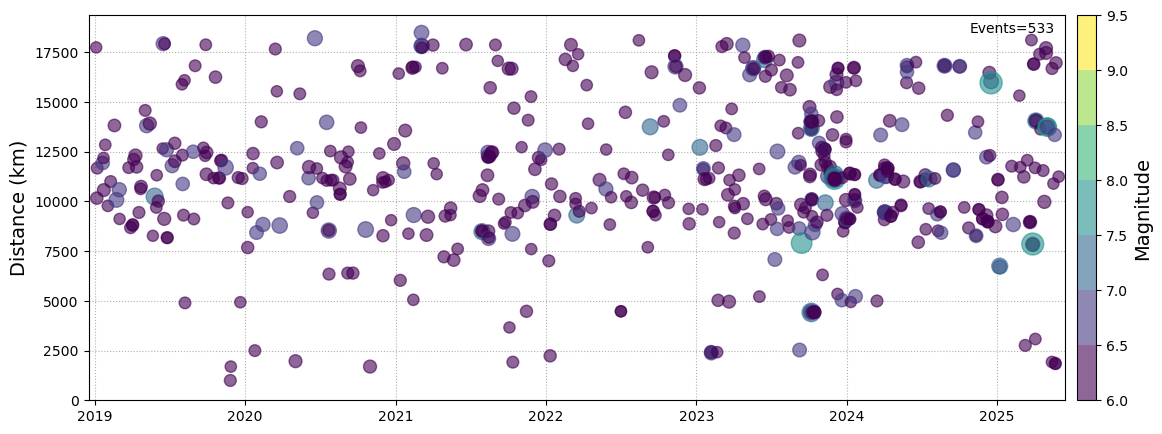

In [10]:
fig = __plot_timeline(events_df)

# fig.savefig(config['outpath_figs']+f"Plot_timeline_{config['eventfile']}_{config['str_dates']}.png", 
#             format="png", dpi=150, bbox_inches="tight", pad_inches=0.05)


### store catalogs

In [11]:
# write data frame as pickle file
events_df.to_pickle(config['outpath']+config['eventfile']+".pkl")